In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

In [2]:
# Get the dataset.
# It has 70000 items, so might take a while to download
dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\sebas\tensorflow_datasets\glue\sst2\2.0.0.incompleteJLDAID\glue-train.tfrecord*...:   0%|  …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\sebas\tensorflow_datasets\glue\sst2\2.0.0.incompleteJLDAID\glue-validation.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\sebas\tensorflow_datasets\glue\sst2\2.0.0.incompleteJLDAID\glue-test.tfrecord*...:   0%|   …

Dataset glue downloaded and prepared to C:\Users\sebas\tensorflow_datasets\glue\sst2\2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [3]:
# Get the training and validation datasets
dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [4]:
# Print some of the entries
for example in dataset_train.take(2):
    review, label = example["sentence"], example["label"]
    print("Review:", review)
    print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [5]:
# Get the sentences and the labels
# for both the training and the validation sets
training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

# The dataset has 67,000 training entries, but that's a lot to process here!

# If you want to take the entire dataset: WARNING: takes longer!!
# for item in dataset_train.take(-1):

# Take 10,000 reviews
for item in dataset_train.take(10000):
    review, label = item["sentence"], item["label"]
    training_reviews.append(str(review.numpy()))
    training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
    print (training_reviews[i])
    print (training_labels[i])

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):
    review, label = item["sentence"], item["label"]
    validation_reviews.append(str(review.numpy()))
    validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
    print (validation_reviews[i])
    print (validation_labels[i])



Number of training reviews is:  10000
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


In [6]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index

In [7]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            64000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))

Epoch 1/20
313/313 [==============================] - 3s 4ms/step - loss: 0.6843 - accuracy: 0.5597 - val_loss: 0.6886 - val_accuracy: 0.5161
Epoch 2/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6730 - accuracy: 0.5698 - val_loss: 0.6733 - val_accuracy: 0.5940
Epoch 3/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6200 - val_loss: 0.6475 - val_accuracy: 0.6445
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6244 - accuracy: 0.6686 - val_loss: 0.6160 - val_accuracy: 0.6892
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5911 - accuracy: 0.7063 - val_loss: 0.5845 - val_accuracy: 0.7190
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5574 - accuracy: 0.7388 - val_loss: 0.5554 - val_accuracy: 0.7248
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5255 - accuracy: 0.7712 - val_loss: 0.5339 - val_accuracy: 0.7362
Epoch 

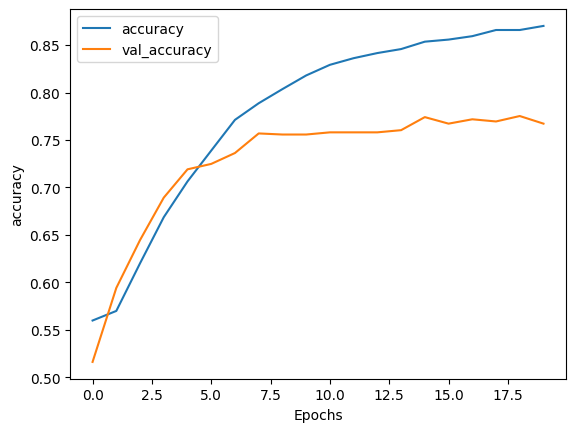

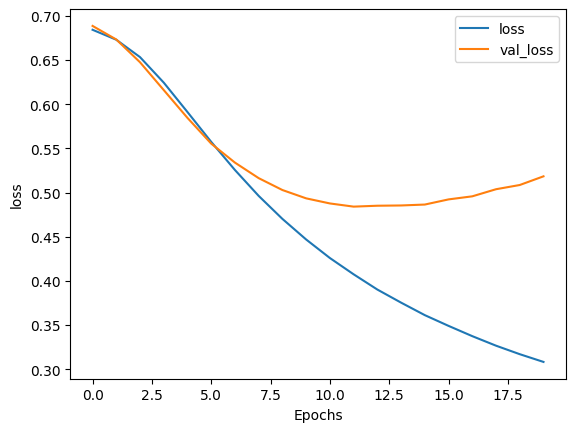

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

In [12]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews

def predict_review(model, reviews):
    # Create the sequences
    padding_type='post'
    sample_sequences = tokenizer.texts_to_sequences(reviews)
    reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                   maxlen=max_length)
    classes = model.predict(reviews_padded)
    for x in range(len(reviews_padded)):
        print(reviews[x])
        print(classes[x])
        print('\n')

predict_review(model, new_reviews)

1/1 [==============================] - 0s 65ms/step
I loved this movie
[0.39485863]


that was the worst movie I've ever seen
[0.11633323]


too much violence even for a Bond film
[0.03024292]


a captivating recounting of a cherished myth
[0.60214996]




In [13]:
def fit_model_and_show_results (model, reviews):
        model.summary()
    history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                        validation_data=(validation_padded, validation_labels_final))
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")
    predict_review(model, reviews)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            64000     
                                                                 
 conv1d (Conv1D)             (None, 46, 16)            1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 7s 4ms/step - loss: 0.6886 - accuracy: 0.5573 - val_loss: 0.69

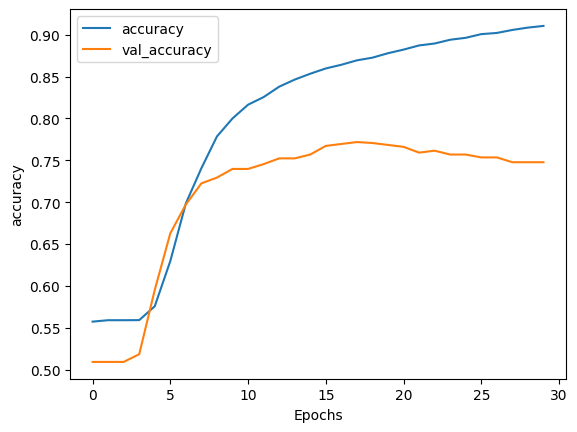

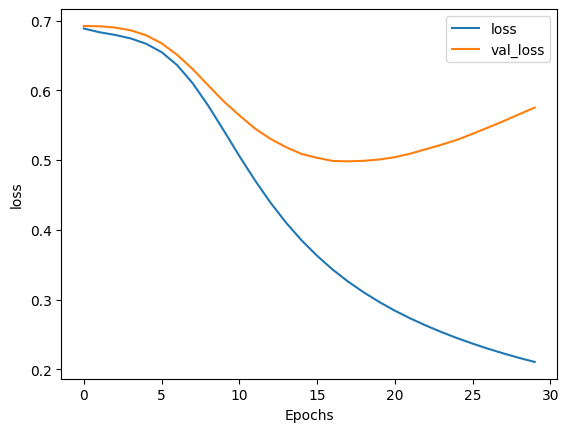

1/1 [==============================] - 0s 57ms/step
I loved this movie
[0.9173315]


that was the worst movie I've ever seen
[0.00349248]


too much violence even for a Bond film
[0.00493451]


a captivating recounting of a cherished myth
[0.7977422]




In [14]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 6s 11ms/step - loss: 0.6903 - accuracy: 0.5503 - val_loss: 0.6928 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 2s 8ms/step - loss: 0.6864 - accuracy: 0.5590 - val

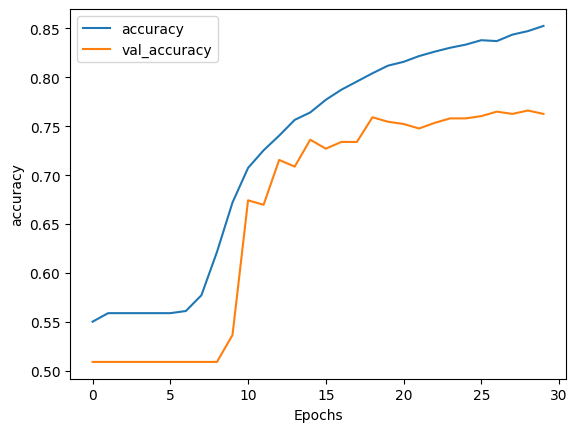

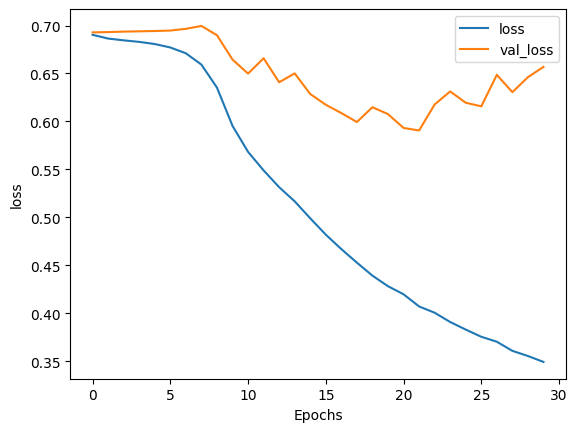

1/1 [==============================] - 0s 451ms/step
I loved this movie
[0.33405358]


that was the worst movie I've ever seen
[0.14461787]


too much violence even for a Bond film
[0.08225522]


a captivating recounting of a cherished myth
[0.483441]




In [15]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 6s 12ms/step - loss: 0.6894 - accuracy: 0.5590 - val_loss: 0.6934 - val_accuracy: 0.5092
Epoch 2/30
313/313 [==============================] - 3s 9ms/step - loss: 0.6867 - accuracy: 0.5590 - val

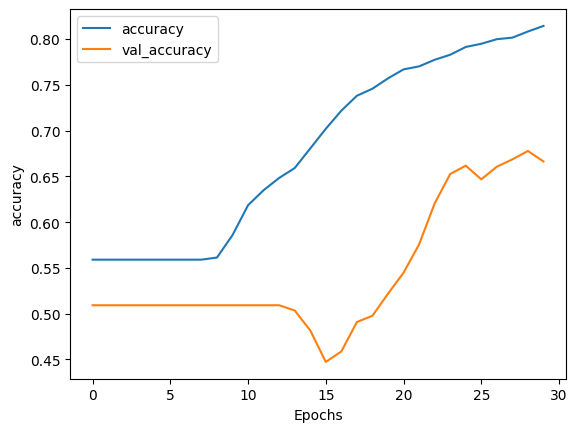

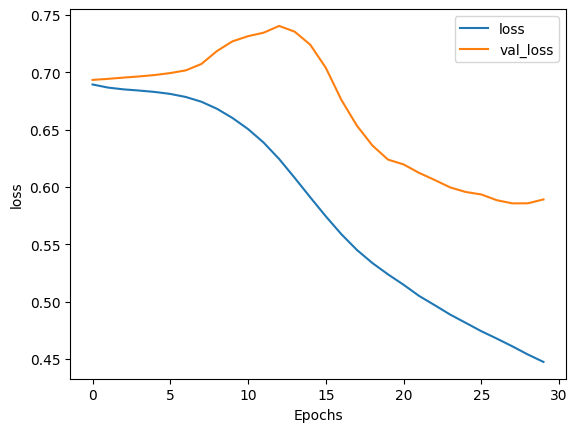

1/1 [==============================] - 0s 457ms/step
I loved this movie
[0.53324825]


that was the worst movie I've ever seen
[0.38836205]


too much violence even for a Bond film
[0.45180658]


a captivating recounting of a cherished myth
[0.5896198]




In [16]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================

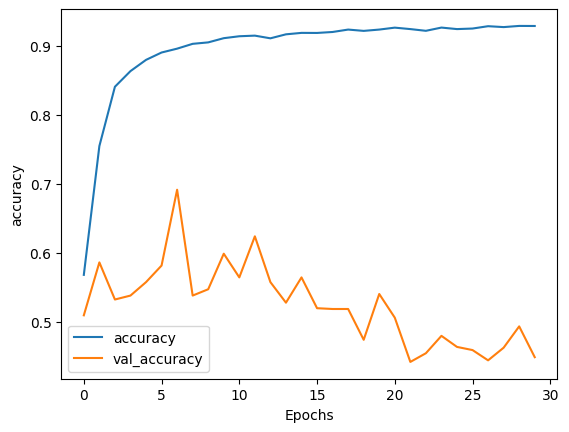

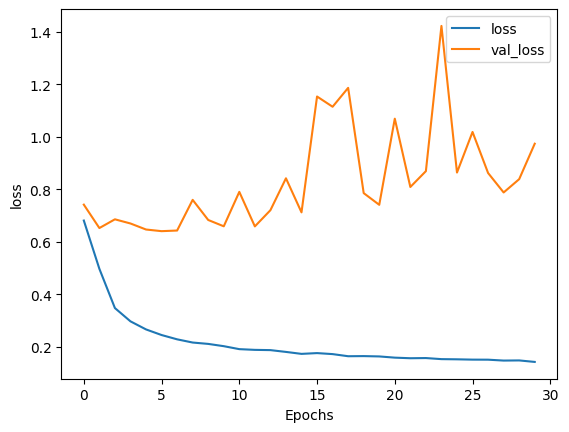

1/1 [==============================] - 1s 949ms/step
I loved this movie
[0.9695542]


that was the worst movie I've ever seen
[0.6530793]


too much violence even for a Bond film
[0.01195539]


a captivating recounting of a cherished myth
[0.9920449]




In [17]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

In [18]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director
 who made my most favorite movie ever, I was very disappointed in the tedious
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7,
                review8, review9, review10]

In [19]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
1/1 [==============================] - 0s 16ms/step
I loved this movie
[0.39485863]


that was the worst movie I've ever seen
[0.11633323]


too much violence even for a Bond film
[0.03024292]


a captivating recounting of a cherished myth
[0.60214996]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.30669925]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.47238323]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.27132526]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5056799]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappoin

In [20]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 [==============================] - 0s 20ms/step
I loved this movie
[0.9173315]


that was the worst movie I've ever seen
[0.00349248]


too much violence even for a Bond film
[0.00493451]


a captivating recounting of a cherished myth
[0.7977422]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.55526567]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.8828468]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.17910917]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.64034504]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the

In [21]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
1/1 [==============================] - 0s 17ms/step
I loved this movie
[0.33403787]


that was the worst movie I've ever seen
[0.14462087]


too much violence even for a Bond film
[0.08225756]


a captivating recounting of a cherished myth
[0.48343295]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.08936426]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.11542062]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.08964749]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.20004895]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very di

In [22]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 [==============================] - 0s 18ms/step
I loved this movie
[0.532704]


that was the worst movie I've ever seen
[0.3879169]


too much violence even for a Bond film
[0.45122856]


a captivating recounting of a cherished myth
[0.5891516]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.19936128]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.35872158]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.18340553]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.42718762]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was 

In [23]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 [==============================] - 0s 21ms/step
I loved this movie
[0.96954644]


that was the worst movie I've ever seen
[0.6530715]


too much violence even for a Bond film
[0.01195558]


a captivating recounting of a cherished myth
[0.9920441]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.902868]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99823207]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.9973465]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9966714]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was ve